In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.integrate import solve_ivp
from scipy.stats import ttest_ind
from scipy.optimize import curve_fit
from scipy.optimize import minimize

### Data Cleaning
Performed in original excel data file
- Cleaned data with 4 and 6 letters. rprobe -> probe, tash -> trash, clen -> clean
- Removed extra spaces.
- Adjusted Mar 27th 2022 data. Sum before adjustment was 126%. After adjustment, it is 100%.


In [ ]:
# read initial xlsx

if (os.path.exists("Problem_C_Data_Wordle_with_freq.xlsx")):
    xls = pd.ExcelFile('Problem_C_Data_Wordle_with_freq.xlsx')
    df = xls.parse('Sheet1')
    print("File loaded")
    print(df.columns)
else:
    xls = pd.ExcelFile('Problem_C_Data_Wordle.xlsx')
    df = xls.parse('Sheet1')
    words = df["Word"]
    words = words.str.lower()

    word_frequency = [word_frequency(word, 'en') for word in words]

    df["Word Frequency"] = word_frequency

    df.to_excel("Problem_C_Data_Wordle_with_freq.xlsx", index=False)

    print("Sheet with freq created")
    print("File loaded")

df.head()

File loaded
Index(['Date', 'Contest number', 'Word', 'Number of  reported results',
       'Number in hard mode', '1 try', '2 tries', '3 tries', '4 tries',
       '5 tries', '6 tries', '7 or more tries (X)', 'Word Frequency'],
      dtype='object')


,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),Word Frequency
0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2,4.570000e-06
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,9.770000e-07
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,3.160000e-06
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,2.290000e-07
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,4.270000e-06


/var/folders/zz/ppfkxxr528z7gt7qtckqzwd40000gn/T/ipykernel_14121/571223910.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


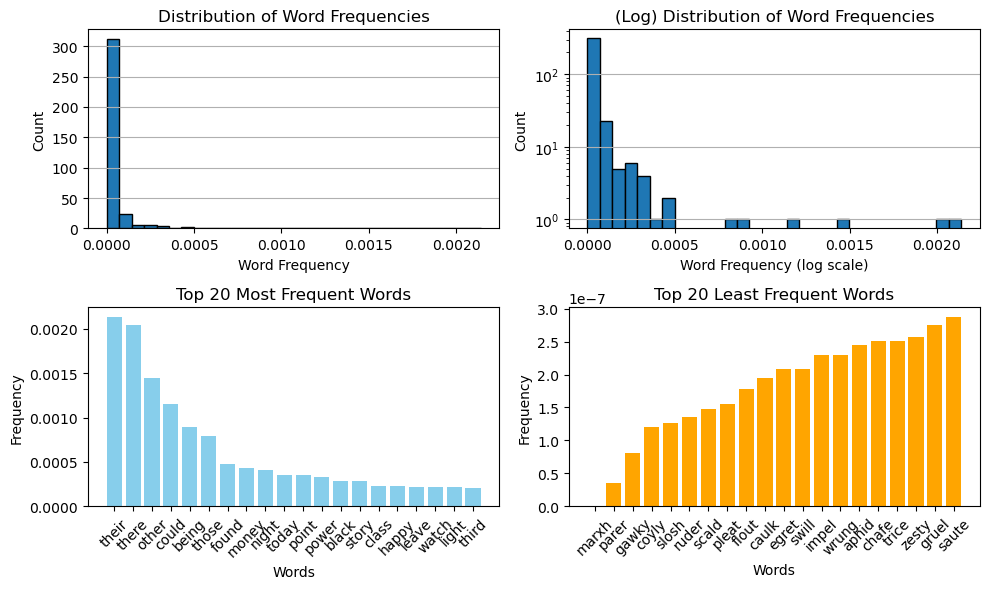

In [ ]:
top_words = df.nlargest(20, "Word Frequency")
least_words = df.nsmallest(20, "Word Frequency")

fig, axes = plt.subplots(2, 2, figsize=(10,6))
fig.tight_layout(pad=5.0)

# 1. Histogram of Word Frequencies
axes[0, 0].hist(df["Word Frequency"], bins=30, edgecolor="k")
axes[0, 0].set_title("Distribution of Word Frequencies")
axes[0, 0].set_xlabel("Word Frequency")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(axis="y")

# 2. Logarithmic Scale Distribution
axes[0, 1].hist(df["Word Frequency"], bins=30, edgecolor="k", log=True)
axes[0, 1].set_title("(Log) Distribution of Word Frequencies")
axes[0, 1].set_xlabel("Word Frequency (log scale)")
axes[0, 1].set_ylabel("Count")
axes[0, 1].grid(axis="y")

# 3. Top 20 Most Frequent Words
axes[1, 0].bar(top_words["Word"], top_words["Word Frequency"], color="skyblue")
axes[1, 0].set_title("Top 20 Most Frequent Words")
axes[1, 0].set_xlabel("Words")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].tick_params(axis="x", rotation=45, labelsize=10)

# 4. Top 20 Least Frequent Words
axes[1, 1].bar(least_words["Word"], least_words["Word Frequency"], color="orange")
axes[1, 1].set_title("Top 20 Least Frequent Words")
axes[1, 1].set_xlabel("Words")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].tick_params(axis="x", rotation=45, labelsize=10)

plt.tight_layout()
plt.savefig("explore_frequency.png", dpi=300)
plt.show()

In [ ]:
df.head()

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),Word Frequency
0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2,4.570000e-06
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,9.770000e-07
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,3.160000e-06
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,2.290000e-07
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,4.270000e-06


In [ ]:
rename_columns = {
    "1 try": 1,
    "2 tries": 2,
    "3 tries": 3,
    "4 tries": 4,
    "5 tries": 5,
    "6 tries": 6,
    "7 or more tries (X)": 7,
}
df.rename(columns=rename_columns, inplace=True)

# calc. proportions
try_columns = [1, 2, 3, 4, 5, 6, 7]
df["total"] = df[try_columns].sum(axis=1)
for col in try_columns:
    df[col] = df[col] / df["total"]

df.head()

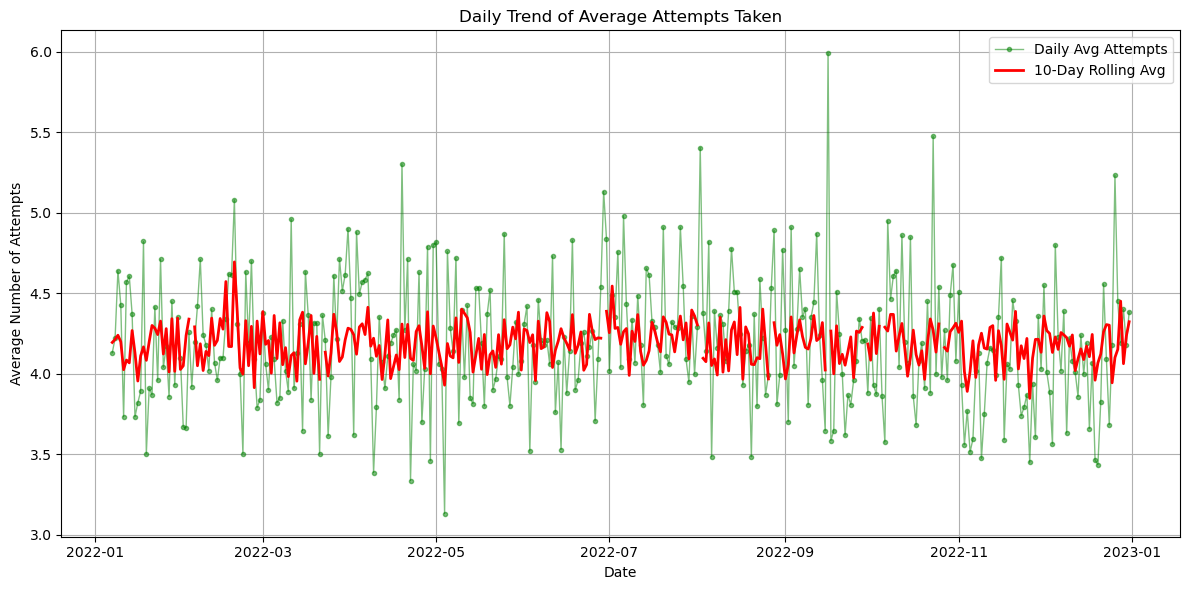

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df["Avg Attempts"] = df[[1, 2, 3, 4, 5, 6, 7]].mul([1, 2, 3, 4, 5, 6, 7], axis=1).sum(axis=1)

# Set the rolling window size (e.g., 7 days for weekly rolling average)
rolling_window = 10
df["Rolling Avg Attempts"] = df["Avg Attempts"].rolling(window=rolling_window).mean()


df = df.sort_values("Date")
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Avg Attempts"], marker="o", linestyle="-", color="green", alpha=0.5, label="Daily Avg Attempts", linewidth=1, markersize=3)
plt.plot(df["Date"], df["Rolling Avg Attempts"], linestyle="-", color="red", linewidth=2, label=f"{rolling_window}-Day Rolling Avg")
plt.xlabel("Date")
plt.ylabel("Average Number of Attempts")
plt.title("Daily Trend of Average Attempts Taken")
plt.legend()
plt.grid()
plt.tight_layout()
# plt.savefig("data/explore_daily_trend.png", dpi=300)
plt.show()
